# Projet Pacte : Maintenance Prédictive
Le projet de Maintenance Prédictive consiste à anticiper les défaillances potentielles des machines industrielles avant qu'elles ne surviennent, permettant ainsi une gestion proactive et plus efficace des opérations. L'objectif principal est de prédire la probabilité qu'une machine tombe en panne et de déterminer quel type de panne pourrait se produire, ce qui permet de planifier les interventions de maintenance de manière optimale et de minimiser les temps d'arrêt non planifiés.

### 1. Objectifs du projet :
- Prédiction de la panne (classification binaire) : Identifier si une machine tombera en panne ou non à un moment donné.
- Prédiction du type de panne (classification multi-classe) : Identifier le type spécifique de panne qui pourrait se produire (par exemple, panne de puissance, panne mécanique, etc.).

Les données utilisées pour ce projet sont fournies par l'UCI dans le cadre d'un dataset de maintenance prédictive. Ce dataset contient des informations provenant de diverses machines, avec des mesures de différents paramètres liés à la performance des machines, comme la température, la vitesse de rotation, le couple, l'usure des outils, etc. Ces paramètres permettent de modéliser et de prévoir les pannes.

### Le dataset est constitué des colonnes suivantes :

- UDI : Identifiant unique de la machine.
- Product ID : Identifiant du produit/machine.
- Type : Type de la machine (M, L, H).
- Air temperature [K] : Température de l'air en Kelvin.
- Process temperature [K] : Température du processus en Kelvin.
- Rotational speed [rpm] : Vitesse de rotation de la machine (en tours par minute).
- Torque [Nm] : Couple appliqué sur la machine (en Newton-mètre).
- Tool wear [min] : Usure de l'outil en minutes.
- Target : La variable cible, indiquant si une panne a eu lieu (0 = pas de panne, 1 = panne).
- Failure Type : Type de la panne (par exemple, "Power Failure", "Overheating", etc.).

### Variable cible
Pour la classification binaire : **Target**

Pour la classification multiclasse : **Failure Type**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

### 2. Exploration et Préparation des Données
#### 2.1 Chargement et Analyse Initiale


In [17]:
# 1. Chargement des données
data = pd.read_csv("predictive_maintenance.csv")  # Remplace avec le vrai chemin du fichier

In [18]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [19]:
data.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [20]:
# Vérification des doublons
duplicates = data.duplicated()
print(f"\nNombre de doublons dans le dataset : {duplicates.sum()}")

# Suppression des doublons si nécessaire
data = data.drop_duplicates()
print(f"Nouvelle taille du dataset après suppression des doublons : {data.shape}")



Nombre de doublons dans le dataset : 0
Nouvelle taille du dataset après suppression des doublons : (10000, 10)


Nombre de doublons dans le dataset : 0
Nouvelle taille du dataset après suppression des doublons : (10000, 10)

In [21]:
# suppression des colonnes inutiles
data.drop(['UDI', 'Product ID' ], axis=1, inplace=True)

In [22]:
# Separation des vaiables categoriques et numeriques
var_cat = ['Type', 'Failure Type', 'Target']
var_num = ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

#### 2.2 Gestion des Données Manquantes et Anormales

In [23]:
# Données manquantes
data.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [24]:
# Détection des valeurs aberrantes avec la méthode IQR (Interquartile Range)
def detect_outliers_iqr(data, threshold=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return (data < lower_bound) | (data > upper_bound)

In [25]:
# Identification des valeurs aberrantes dans les variables numériques
outliers = data[var_num].apply(detect_outliers_iqr)
outlier_counts = outliers.sum()
print("\nNombre de valeurs aberrantes détectées par colonne :")
print(outlier_counts)


Nombre de valeurs aberrantes détectées par colonne :
Air temperature [K]          0
Process temperature [K]      0
Rotational speed [rpm]     418
Torque [Nm]                 69
Tool wear [min]              0
dtype: int64


Text(0.5, 1.0, 'Boxplot des variables numériques')

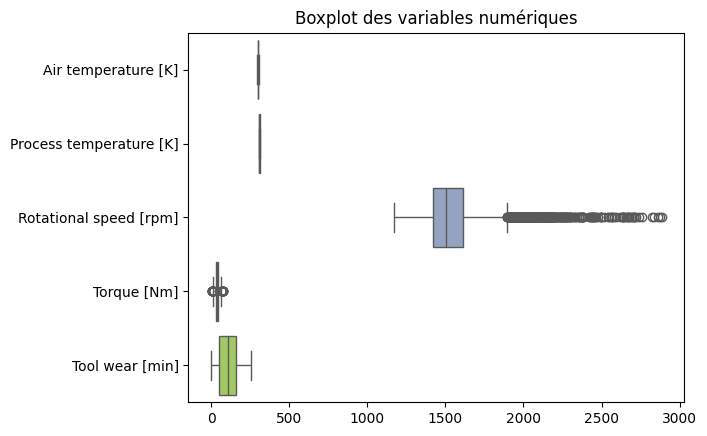

In [26]:
sns.boxplot(data=data[var_num], orient="h", palette="Set2")
plt.title("Boxplot des variables numériques")

On garde les valeurs aberrantes parce que ces variables sont des mesures physiques

#### 2.3 Analyse Descriptive et Visualisation

In [27]:
# 3. Analyse descriptive
print("\nStatistiques descriptives :")
data.describe()


Statistiques descriptives :


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


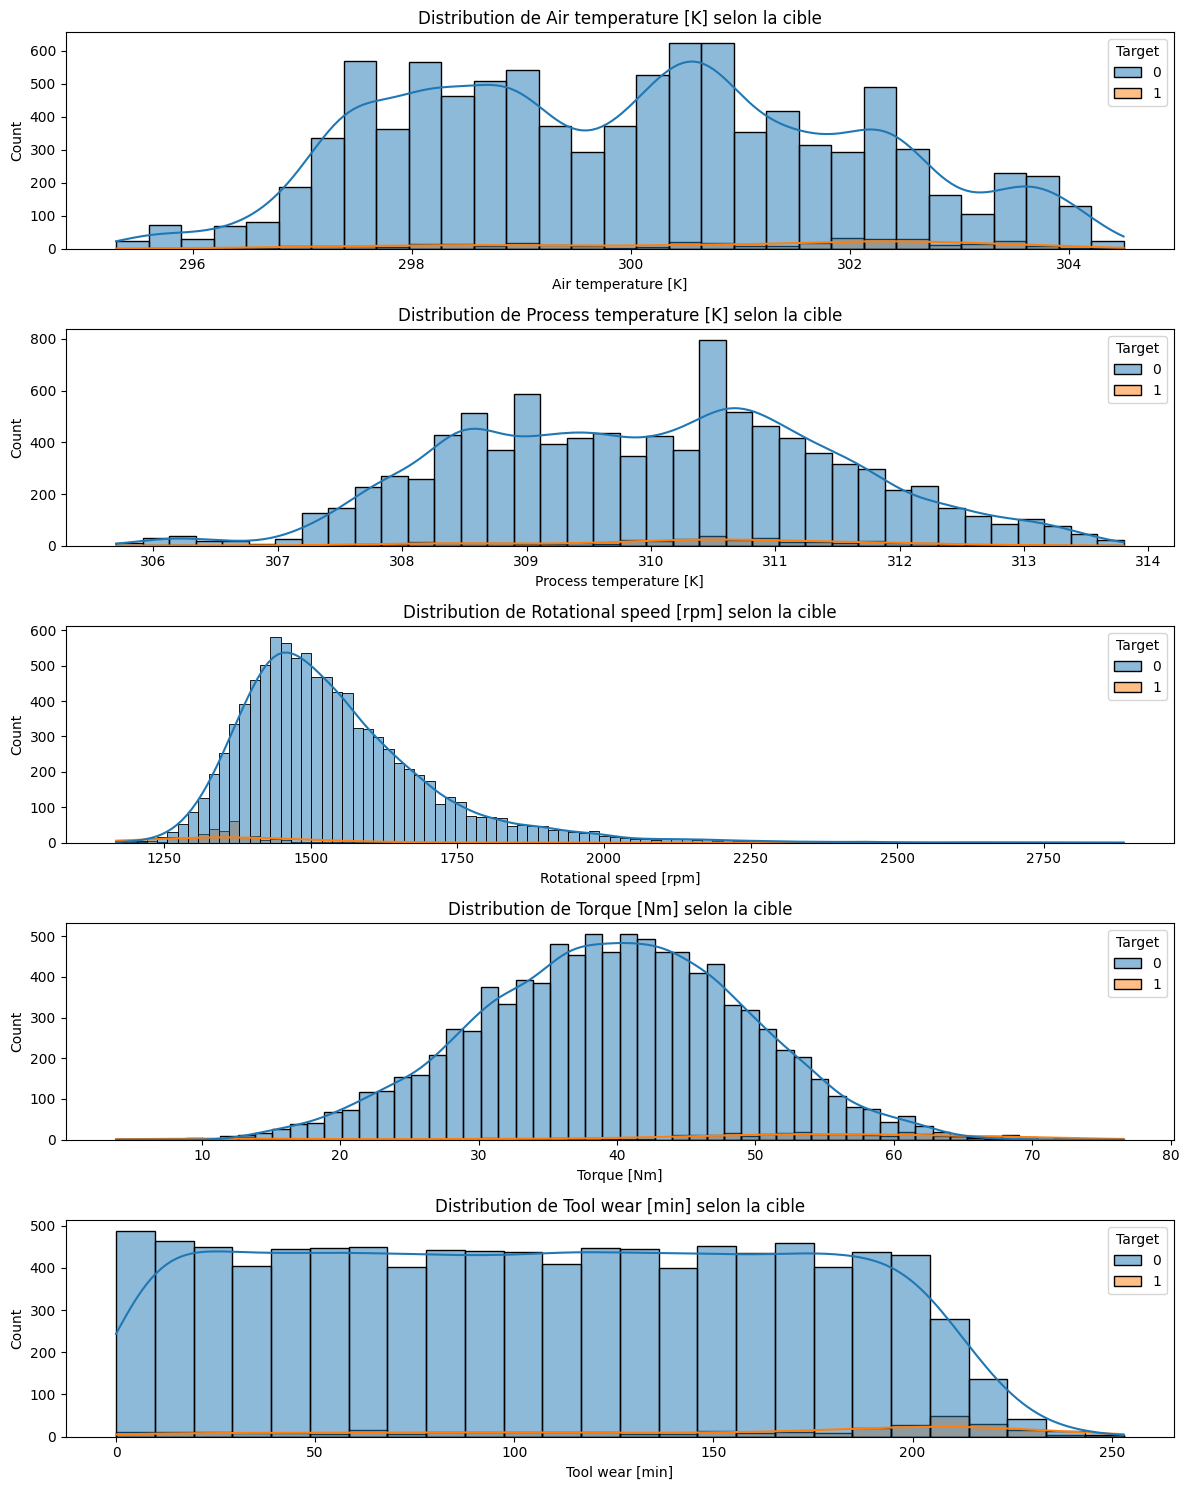

In [28]:
fig, axes = plt.subplots(nrows=len(var_num), figsize=(12, 15))
for i, feature in enumerate(var_num):
    sns.histplot(data=data, x=feature, hue='Target', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {feature} selon la cible')
plt.tight_layout()
plt.show()

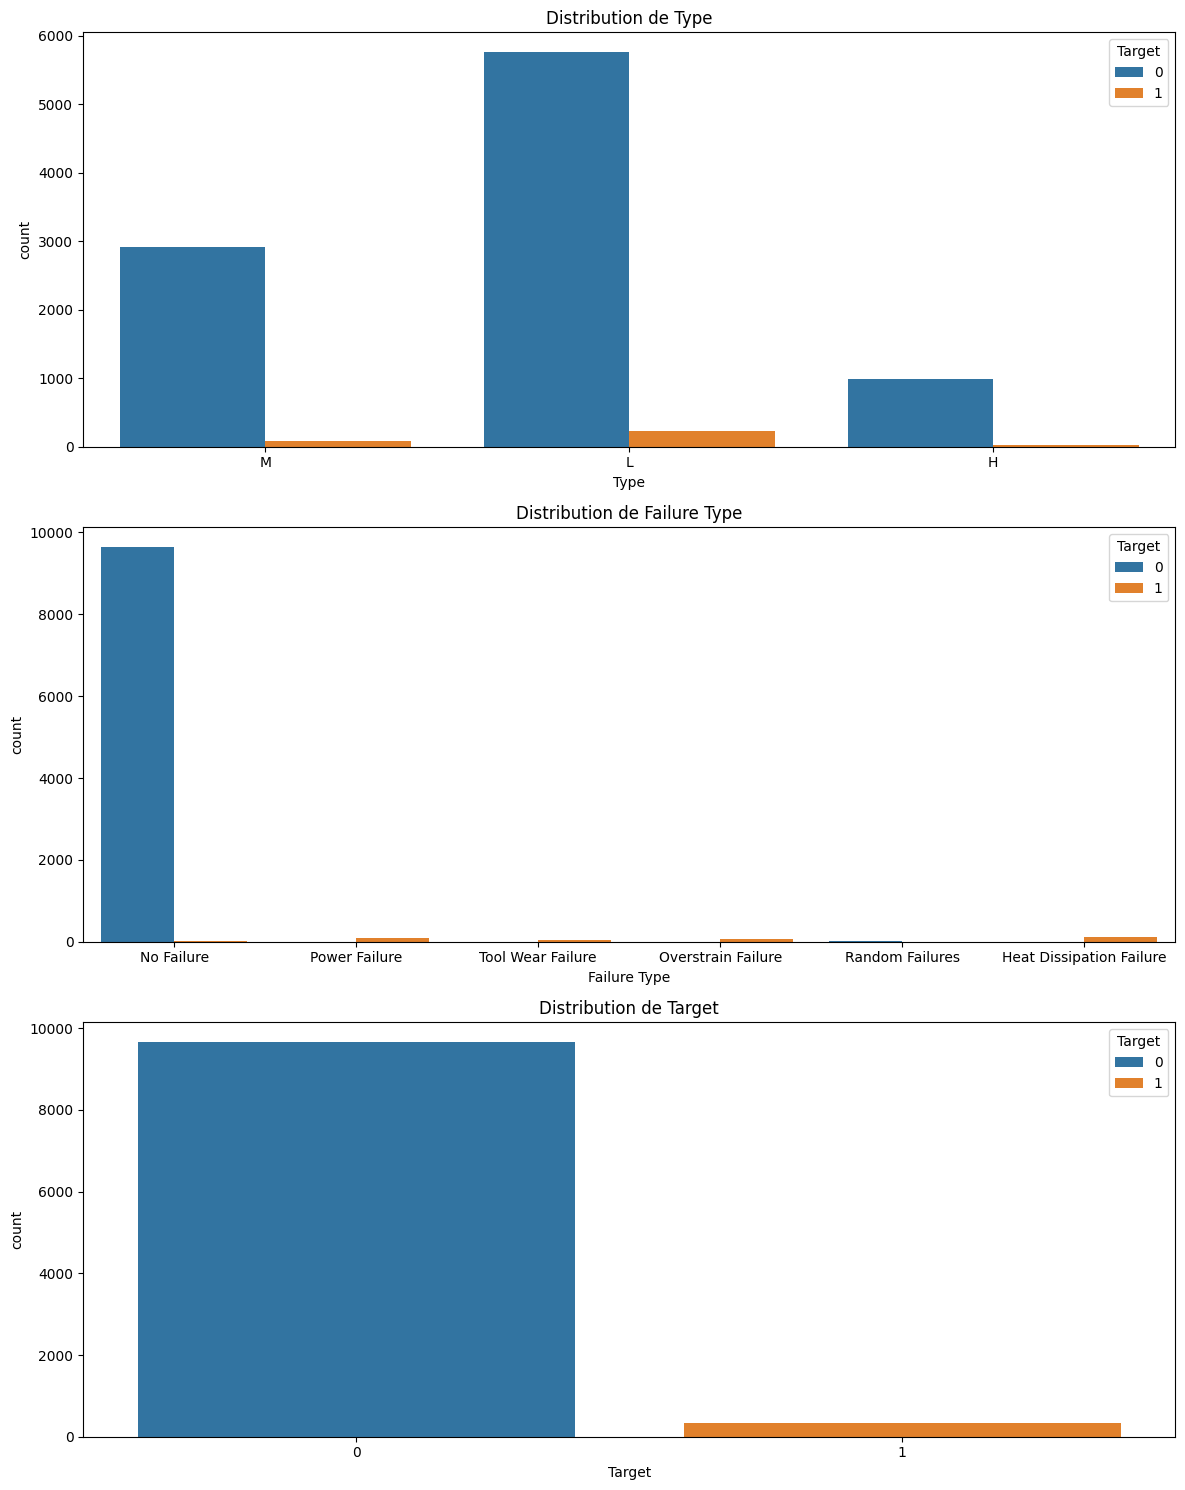

In [29]:
fig, axes = plt.subplots(nrows=len(var_cat), figsize=(12, 15))
for i, feature in enumerate(var_cat):
    sns.countplot(data=data, x=feature, hue='Target', ax=axes[i])
    axes[i].set_title(f'Distribution de {feature}')
plt.tight_layout()
plt.show()

Les classes sont très déséquilibrées. Nécessité de faire de l'équilibration

In [30]:
# Encodage des variables catégorielles
label_encoder = LabelEncoder()
data['Type_encoded'] = label_encoder.fit_transform(data['Type'])

In [31]:
# Création d'une variable pour le type de panne (pour la classification multi-classe)
failure_encoder = LabelEncoder()
data['Failure_Type_encoded'] = failure_encoder.fit_transform(data['Failure Type'])
failure_mapping = dict(zip(failure_encoder.classes_, failure_encoder.transform(failure_encoder.classes_)))
print("\nMapping des types de panne:")
print(failure_mapping)


Mapping des types de panne:
{'Heat Dissipation Failure': np.int64(0), 'No Failure': np.int64(1), 'Overstrain Failure': np.int64(2), 'Power Failure': np.int64(3), 'Random Failures': np.int64(4), 'Tool Wear Failure': np.int64(5)}


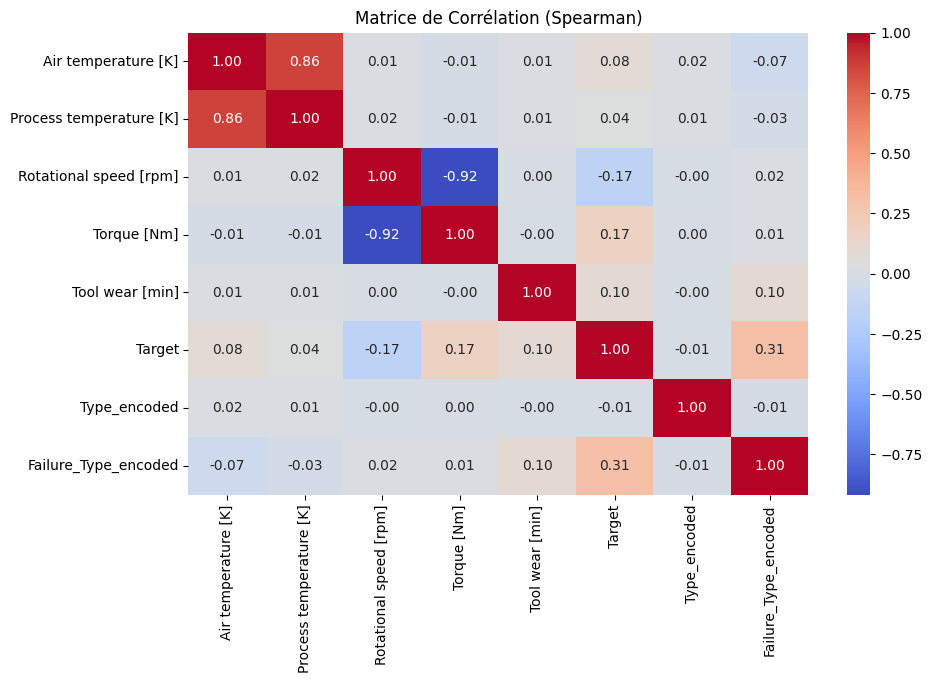

In [32]:
# 6. Matrice de corrélation (Spearman)
plt.figure(figsize=(10,6))
sns.heatmap(data[var_num + ["Target", "Type_encoded", "Failure_Type_encoded"]].corr(method='spearman'), annot=True , cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation (Spearman)")
plt.show()

In [33]:
# Sélection des caractéristiques numériques pour la modélisation
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
            'Torque [Nm]', 'Tool wear [min]', 'Type_encoded']

# Séparation des données en caractéristiques et cibles
X = data[features]
y_binary = data['Target']  # Pour la classification binaire
y_multiclass = data['Failure_Type_encoded']  # Pour la classification multi-classe

# Division des données en ensembles d'entraînement et de test (70% / 30%)
X_train, X_test, y_binary_train, y_binary_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=42)

X_train_multi, X_test_multi, y_multi_train, y_multi_test = train_test_split(
    X, y_multiclass, test_size=0.3, random_state=42)

# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

# Vérification de l'équilibre des classes pour la classification binaire
print("\nDistribution des classes pour la classification binaire:")
print(y_binary.value_counts())

# Vérification de l'équilibre des classes pour la classification multi-classe
print("\nDistribution des classes pour la classification multi-classe:")
print(y_multiclass.value_counts())


Distribution des classes pour la classification binaire:
Target
0    9661
1     339
Name: count, dtype: int64

Distribution des classes pour la classification multi-classe:
Failure_Type_encoded
1    9652
0     112
3      95
2      78
5      45
4      18
Name: count, dtype: int64


#### 3. Gestion des données déséquilibrées
Pour traiter le problème de déséquilibre de classes, j'utiliserai deux méthodes: SMOTE et RandomOverSampler. Je les appliquerai uniquement sur les données d'entraînement, en gardant les données de test intactes pour une évaluation plus réaliste.

In [34]:
# Gestion des données déséquilibrées pour la classification binaire
smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state=42)

# Application de SMOTE
X_train_smote, y_binary_train_smote = smote.fit_resample(X_train_scaled, y_binary_train)

# Application de RandomOverSampler
X_train_ros, y_binary_train_ros = ros.fit_resample(X_train_scaled, y_binary_train)

# Vérification des distributions après rééquilibrage pour la classification binaire
print("Distribution des classes originale pour la classification binaire:")
print(pd.Series(y_binary_train).value_counts())

print("\nDistribution des classes après SMOTE pour la classification binaire:")
print(pd.Series(y_binary_train_smote).value_counts())

print("\nDistribution des classes après RandomOverSampler pour la classification binaire:")
print(pd.Series(y_binary_train_ros).value_counts())

# Gestion des données déséquilibrées pour la classification multi-classe
# Application de SMOTE
X_train_multi_smote, y_multi_train_smote = smote.fit_resample(X_train_multi_scaled, y_multi_train)

# Application de RandomOverSampler
X_train_multi_ros, y_multi_train_ros = ros.fit_resample(X_train_multi_scaled, y_multi_train)

# Vérification des distributions après rééquilibrage pour la classification multi-classe
print("\nDistribution des classes originale pour la classification multi-classe:")
print(pd.Series(y_multi_train).value_counts())

print("\nDistribution des classes après SMOTE pour la classification multi-classe:")
print(pd.Series(y_multi_train_smote).value_counts())

print("\nDistribution des classes après RandomOverSampler pour la classification multi-classe:")
print(pd.Series(y_multi_train_ros).value_counts())

Distribution des classes originale pour la classification binaire:
Target
0    6754
1     246
Name: count, dtype: int64

Distribution des classes après SMOTE pour la classification binaire:
Target
0    6754
1    6754
Name: count, dtype: int64

Distribution des classes après RandomOverSampler pour la classification binaire:
Target
0    6754
1    6754
Name: count, dtype: int64

Distribution des classes originale pour la classification multi-classe:
Failure_Type_encoded
1    6749
0      89
3      64
2      56
5      31
4      11
Name: count, dtype: int64

Distribution des classes après SMOTE pour la classification multi-classe:
Failure_Type_encoded
1    6749
5    6749
0    6749
3    6749
2    6749
4    6749
Name: count, dtype: int64

Distribution des classes après RandomOverSampler pour la classification multi-classe:
Failure_Type_encoded
1    6749
5    6749
0    6749
3    6749
2    6749
4    6749
Name: count, dtype: int64


#### 4. Sélection de variables
Je vais utiliser quatre méthodes différentes pour la sélection des variables les plus pertinentes:
+ Sélection récursive des caractéristiques (RFE)
+ Régression Lasso
+ Sélection basée sur la corrélation
+ Importance des variables selon les arbres de décision

In [35]:
######## 1. Sélection récursive des caractéristiques (RFE) ########
print("1. SÉLECTION RFE")

# Pour la classification binaire
estimator = LogisticRegression(max_iter=1000)
selector_rfe = RFE(estimator, n_features_to_select=3, step=1)
selector_rfe.fit(X_train_scaled, y_binary_train)

# Identifier les caractéristiques sélectionnées
selected_features_rfe = [features[i] for i in range(len(features)) if selector_rfe.support_[i]]
print("\nRFE - Caractéristiques sélectionnées pour la classification binaire:")
print(selected_features_rfe)

# Importance des caractéristiques
print("RFE - Classement des caractéristiques:")
for i, feature in enumerate(features):
    print(f"{feature}: {selector_rfe.ranking_[i]}")

# Création des jeux de données avec les caractéristiques sélectionnées par RFE
X_train_rfe = X_train_scaled[:, selector_rfe.support_]
X_test_rfe = X_test_scaled[:, selector_rfe.support_]

# Pour la classification multi-classe
estimator_multi = RandomForestClassifier(random_state=42)
selector_rfe_multi = RFE(estimator_multi, n_features_to_select=3, step=1)
selector_rfe_multi.fit(X_train_multi_scaled, y_multi_train)

# Identifier les caractéristiques sélectionnées
selected_features_rfe_multi = [features[i] for i in range(len(features)) if selector_rfe_multi.support_[i]]
print("\nRFE - Caractéristiques sélectionnées pour la classification multi-classe:")
print(selected_features_rfe_multi)

# Création des jeux de données avec les caractéristiques sélectionnées par RFE
X_train_multi_rfe = X_train_multi_scaled[:, selector_rfe_multi.support_]
X_test_multi_rfe = X_test_multi_scaled[:, selector_rfe_multi.support_]

######## 2. Sélection avec Lasso ########
print("\n\n2. SÉLECTION LASSO")

# Pour la classification binaire
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_binary_train)
optimal_alpha = lasso_cv.alpha_

lasso = Lasso(alpha=optimal_alpha)
lasso.fit(X_train_scaled, y_binary_train)

# Identifier les caractéristiques importantes selon Lasso
lasso_importance = np.abs(lasso.coef_)
selected_features_lasso = [features[i] for i in range(len(features)) if lasso_importance[i] > 0]
print("\nLasso - Caractéristiques sélectionnées pour la classification binaire:")
print(selected_features_lasso)

# Importance des caractéristiques
print("Lasso - Coefficients pour chaque caractéristique:")
for i, feature in enumerate(features):
    print(f"{feature}: {lasso.coef_[i]}")

# Création des jeux de données avec les caractéristiques sélectionnées par Lasso
lasso_support = lasso_importance > 0
X_train_lasso = X_train_scaled[:, lasso_support]
X_test_lasso = X_test_scaled[:, lasso_support]

# Pour la classification multi-classe
# Comme Lasso est conçu pour la régression, nous utiliserons une approche one-vs-rest
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

lasso_clf = OneVsRestClassifier(LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=1000))
lasso_clf.fit(X_train_multi_scaled, y_multi_train)

# Calculer l'importance moyenne des caractéristiques à travers les différentes classes
lasso_importance_multi = np.mean([np.abs(clf.coef_[0]) for clf in lasso_clf.estimators_], axis=0)
selected_features_lasso_multi = [features[i] for i in range(len(features)) if lasso_importance_multi[i] > 0.1]
print("\nLasso - Caractéristiques sélectionnées pour la classification multi-classe:")
print(selected_features_lasso_multi)

# Création des jeux de données avec les caractéristiques sélectionnées par Lasso
lasso_multi_support = lasso_importance_multi > 0.1
X_train_multi_lasso = X_train_multi_scaled[:, lasso_multi_support]
X_test_multi_lasso = X_test_multi_scaled[:, lasso_multi_support]

######## 3. Sélection basée sur la corrélation ########
print("\n\n3. SÉLECTION PAR CORRÉLATION")

# Pour la classification binaire
# Concaténer les caractéristiques et la cible dans un seul DataFrame
df_corr = pd.DataFrame(X_train, columns=features)
df_corr['Target'] = y_binary_train

# Calculer la matrice de corrélation
corr_matrix = df_corr.corr()
corr_with_target = corr_matrix['Target'].abs().sort_values(ascending=False)

print("\nCorrélation des caractéristiques avec la cible (classification binaire):")
print(corr_with_target)

# Sélectionner les caractéristiques avec une corrélation absolue > 0.1 avec la cible
selected_features_corr = corr_with_target[corr_with_target > 0.1].index.tolist()
selected_features_corr.remove('Target')  # Retirer la cible elle-même
print("\nCaractéristiques sélectionnées par corrélation pour la classification binaire:")
print(selected_features_corr)

# Création des jeux de données avec les caractéristiques sélectionnées par corrélation
corr_indices = [features.index(feature) for feature in selected_features_corr]
X_train_corr = X_train_scaled[:, corr_indices]
X_test_corr = X_test_scaled[:, corr_indices]

# Pour la classification multi-classe
# Nous allons utiliser ANOVA F-value pour évaluer la pertinence des caractéristiques pour la prédiction multi-classe
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train_multi_scaled, y_multi_train)

# Scores des caractéristiques
feature_scores = pd.DataFrame({
    'Feature': features,
    'Score': selector.scores_
})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

print("\nScores ANOVA F-value pour la classification multi-classe:")
print(feature_scores)

# Sélectionner les caractéristiques avec les meilleurs scores
selected_features_corr_multi = feature_scores['Feature'].tolist()[:3]
print("\nCaractéristiques sélectionnées par ANOVA pour la classification multi-classe:")
print(selected_features_corr_multi)

# Création des jeux de données avec les caractéristiques sélectionnées par ANOVA
X_train_multi_corr = X_train_multi_scaled[:, selector.get_support()]
X_test_multi_corr = X_test_multi_scaled[:, selector.get_support()]

######## 4. Sélection avec les arbres de décision ########
print("\n\n4. SÉLECTION AVEC ARBRES DE DÉCISION")

# Pour la classification binaire
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_binary_train)

# Importance des caractéristiques
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': dt.feature_importances_
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("\nImportance des caractéristiques selon l'arbre de décision (classification binaire):")
print(feature_importances)

# Sélectionner les caractéristiques avec une importance > 0.1
selected_features_dt = feature_importances[feature_importances['Importance'] > 0.1]['Feature'].tolist()
print("\nCaractéristiques sélectionnées par arbre de décision pour la classification binaire:")
print(selected_features_dt)

# Création des jeux de données avec les caractéristiques sélectionnées par arbre de décision
dt_indices = [features.index(feature) for feature in selected_features_dt]
X_train_dt = X_train_scaled[:, dt_indices]
X_test_dt = X_test_scaled[:, dt_indices]

# Pour la classification multi-classe
dt_multi = DecisionTreeClassifier(random_state=42)
dt_multi.fit(X_train_multi_scaled, y_multi_train)

# Importance des caractéristiques
feature_importances_multi = pd.DataFrame({
    'Feature': features,
    'Importance': dt_multi.feature_importances_
})
feature_importances_multi = feature_importances_multi.sort_values(by='Importance', ascending=False)

print("\nImportance des caractéristiques selon l'arbre de décision (classification multi-classe):")
print(feature_importances_multi)

# Sélectionner les caractéristiques avec une importance > 0.1
selected_features_dt_multi = feature_importances_multi[feature_importances_multi['Importance'] > 0.1]['Feature'].tolist()
print("\nCaractéristiques sélectionnées par arbre de décision pour la classification multi-classe:")
print(selected_features_dt_multi)

# Création des jeux de données avec les caractéristiques sélectionnées par arbre de décision
dt_multi_indices = [features.index(feature) for feature in selected_features_dt_multi]
X_train_multi_dt = X_train_multi_scaled[:, dt_multi_indices]
X_test_multi_dt = X_test_multi_scaled[:, dt_multi_indices]

# Résumé des caractéristiques sélectionnées par chaque méthode
print("\n\nRÉSUMÉ DES CARACTÉRISTIQUES SÉLECTIONNÉES:")
print(f"RFE (binaire): {selected_features_rfe}")
print(f"Lasso (binaire): {selected_features_lasso}")
print(f"Corrélation (binaire): {selected_features_corr}")
print(f"Arbre de décision (binaire): {selected_features_dt}")
print(f"RFE (multi-classe): {selected_features_rfe_multi}")
print(f"Lasso (multi-classe): {selected_features_lasso_multi}")
print(f"ANOVA (multi-classe): {selected_features_corr_multi}")
print(f"Arbre de décision (multi-classe): {selected_features_dt_multi}")

1. SÉLECTION RFE

RFE - Caractéristiques sélectionnées pour la classification binaire:
['Air temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']
RFE - Classement des caractéristiques:
Air temperature [K]: 1
Process temperature [K]: 2
Rotational speed [rpm]: 1
Torque [Nm]: 1
Tool wear [min]: 3
Type_encoded: 4

RFE - Caractéristiques sélectionnées pour la classification multi-classe:
['Air temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']


2. SÉLECTION LASSO

Lasso - Caractéristiques sélectionnées pour la classification binaire:
['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_encoded']
Lasso - Coefficients pour chaque caractéristique:
Air temperature [K]: 0.0423436693402711
Process temperature [K]: -0.029596505418898255
Rotational speed [rpm]: 0.09258924901480621
Torque [Nm]: 0.1149688232016804
Tool wear [min]: 0.02027272803904043
Type_encoded: 0.0011655979111942951

Lasso - Caractéristiques sélectionné

#### 5. Modélisation pour la classification binaire (prédiction de panne)
On va maintenant entraîner différents modèles pour la classification binaire en utilisant les différentes méthodes de sélection de variables et les stratégies de rééquilibrage des classes.

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, feature_selection_method):
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Affichage des résultats
    print(f"\n{model_name} avec {feature_selection_method}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    print("Matrice de confusion:")
    print(cm)
    
    # Rapport de classification détaillé
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred))
    
    return {
        'model_name': model_name,
        'feature_selection': feature_selection_method,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Liste des modèles à évaluer
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Liste des méthodes de sélection de caractéristiques avec leurs noms et datasets
feature_selection_methods = [
    ('Toutes les caractéristiques', X_train_scaled, X_test_scaled),
    ('RFE', X_train_rfe, X_test_rfe),
    ('Lasso', X_train_lasso, X_test_lasso),
    ('Corrélation', X_train_corr, X_test_corr),
    ('Arbre de décision', X_train_dt, X_test_dt)
]

# Liste des méthodes de rééquilibrage
resampling_methods = [
    ('Sans rééquilibrage', X_train_scaled, y_binary_train),
    ('SMOTE', X_train_smote, y_binary_train_smote),
    ('RandomOverSampler', X_train_ros, y_binary_train_ros)
]

# Stockage des résultats pour comparaison
all_results = []

# Évaluation de chaque combinaison de modèle, méthode de sélection et méthode de rééquilibrage
for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"ÉVALUATION DU MODÈLE: {model_name}")
    print(f"{'='*50}")
    
    for resampling_name, X_train_resampled, y_train_resampled in resampling_methods:
        print(f"\n{'-'*50}")
        print(f"MÉTHODE DE RÉÉQUILIBRAGE: {resampling_name}")
        print(f"{'-'*50}")
        
        for fs_name, X_train_fs, X_test_fs in feature_selection_methods:
            if fs_name == 'Toutes les caractéristiques':
                # Si on utilise toutes les caractéristiques, on prend directement le jeu de données rééquilibré
                if resampling_name == 'Sans rééquilibrage':
                    X_train_current = X_train_scaled
                elif resampling_name == 'SMOTE':
                    X_train_current = X_train_smote
                else:  # RandomOverSampler
                    X_train_current = X_train_ros
            else:
                # Pour les autres méthodes de sélection, nous devons recréer les datasets avec les bonnes caractéristiques
                # Cette partie est simplifiée et pourrait nécessiter une adaptation en fonction de vos données
                if resampling_name == 'Sans rééquilibrage':
                    X_train_current = X_train_fs
                elif resampling_name == 'SMOTE':
                    # Appliquer SMOTE sur les caractéristiques sélectionnées
                    smote = SMOTE(random_state=42)
                    X_train_current, y_train_resampled = smote.fit_resample(X_train_fs, y_binary_train)
                else:  # RandomOverSampler
                    # Appliquer RandomOverSampler sur les caractéristiques sélectionnées
                    ros = RandomOverSampler(random_state=42)
                    X_train_current, y_train_resampled = ros.fit_resample(X_train_fs, y_binary_train)
            
            # Évaluation du modèle
            result = evaluate_model(
                model=model.fit(X_train_current, y_train_resampled),
                X_train=X_train_current,
                y_train=y_train_resampled,
                X_test=X_test_fs,
                y_test=y_binary_test,
                model_name=model_name,
                feature_selection_method=f"{fs_name} + {resampling_name}"
            )
            
            all_results.append(result)

# Conversion des résultats en DataFrame pour une meilleure visualisation
results_df = pd.DataFrame(all_results)

# Tri des résultats par F1-score pour identifier les meilleures combinaisons
best_results = results_df.sort_values(by='f1', ascending=False)

print("\n\nTOP 5 DES MEILLEURES COMBINAISONS (par F1-score):")
print(best_results.head())

# Visualisation des résultats
plt.figure(figsize=(12, 8))
sns.barplot(x='model_name', y='f1', hue='feature_selection', data=results_df)
plt.title('Performance des modèles (F1-score)')
plt.xlabel('Modèle')
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ÉVALUATION DU MODÈLE: Random Forest

--------------------------------------------------
MÉTHODE DE RÉÉQUILIBRAGE: Sans rééquilibrage
--------------------------------------------------

Random Forest avec Toutes les caractéristiques + Sans rééquilibrage:
Accuracy: 0.9863
Precision: 0.8939
Recall: 0.6344
F1-score: 0.7421
Matrice de confusion:
[[2900    7]
 [  34   59]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2907
           1       0.89      0.63      0.74        93

    accuracy                           0.99      3000
   macro avg       0.94      0.82      0.87      3000
weighted avg       0.99      0.99      0.99      3000


Random Forest avec RFE + Sans rééquilibrage:
Accuracy: 0.9740
Precision: 0.6364
Recall: 0.3763
F1-score: 0.4730
Matrice de confusion:
[[2887   20]
 [  58   35]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.98      0.

#### 6. Modélisation pour la classification multi-classe (type de panne)
Pour la classification multi-classe, je vais également évaluer différents modèles avec les différentes méthodes de sélection de variables et stratégies de rééquilibrage.

In [ ]:
def evaluate_multiclass_model(model, X_train, y_train, X_test, y_test, model_name, feature_selection_method):
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Affichage des résultats
    print(f"\n{model_name} avec {feature_selection_method}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    print("Matrice de confusion:")
    print(cm)
    
    # Rapport de classification détaillé
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred))
    
    return {
        'model_name': model_name,
        'feature_selection': feature_selection_method,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Liste des modèles à évaluer pour la classification multi-classe
multiclass_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs')
}

# Liste des méthodes de sélection de caractéristiques avec leurs noms et datasets pour la classification multi-classe
multiclass_feature_selection_methods = [
    ('Toutes les caractéristiques', X_train_multi_scaled, X_test_multi_scaled),
    ('RFE', X_train_multi_rfe, X_test_multi_rfe),
    ('Lasso', X_train_multi_lasso, X_test_multi_lasso),
    ('ANOVA', X_train_multi_corr, X_test_multi_corr),
    ('Arbre de décision', X_train_multi_dt, X_test_multi_dt)
]

# Liste des méthodes de rééquilibrage pour la classification multi-classe
multiclass_resampling_methods = [
    ('Sans rééquilibrage', X_train_multi_scaled, y_multi_train),
    ('SMOTE', X_train_multi_smote, y_multi_train_smote),
    ('RandomOverSampler', X_train_multi_ros, y_multi_train_ros)
]

# Stockage des résultats pour comparaison
multiclass_results = []

# Évaluation de chaque combinaison de modèle, méthode de sélection et méthode de rééquilibrage
for model_name, model in multiclass_models.items():
    print(f"\n{'='*50}")
    print(f"ÉVALUATION DU MODÈLE MULTI-CLASSE: {model_name}")
    print(f"{'='*50}")
    
    for resampling_name, X_train_resampled, y_train_resampled in multiclass_resampling_methods:
        print(f"\n{'-'*50}")
        print(f"MÉTHODE DE RÉÉQUILIBRAGE: {resampling_name}")
        print(f"{'-'*50}")
        
        for fs_name, X_train_fs, X_test_fs in multiclass_feature_selection_methods:
            if fs_name == 'Toutes les caractéristiques':
                # Si on utilise toutes les caractéristiques, on prend directement le jeu de données rééquilibré
                if resampling_name == 'Sans rééquilibrage':
                    X_train_current = X_train_multi_scaled
                elif resampling_name == 'SMOTE':
                    X_train_current = X_train_multi_smote
                else:  # RandomOverSampler
                    X_train_current = X_train_multi_ros
            else:
                # Pour les autres méthodes de sélection, nous devons recréer les datasets avec les bonnes caractéristiques
                if resampling_name == 'Sans rééquilibrage':
                    X_train_current = X_train_fs
                elif resampling_name == 'SMOTE':
                    # Appliquer SMOTE sur les caractéristiques sélectionnées
                    smote = SMOTE(random_state=42)
                    X_train_current, y_train_resampled = smote.fit_resample(X_train_fs, y_multi_train)
                else:  # RandomOverSampler
                    # Appliquer RandomOverSampler sur les caractéristiques sélectionnées
                    ros = RandomOverSampler(random_state=42)
                    X_train_current, y_train_reX_train_current, y_train_resampled = ros.fit_resample(X_train_fs, y_multi_train)
            
            # Évaluation du modèle
            result = evaluate_multiclass_model(
                model=model,
                X_train=X_train_current,
                y_train=y_train_resampled,
                X_test=X_test_fs,
                y_test=y_multi_test,
                model_name=model_name,
                feature_selection_method=f"{fs_name} + {resampling_name}"
            )
            
            multiclass_results.append(result)

# Conversion des résultats en DataFrame pour une meilleure visualisation
multiclass_results_df = pd.DataFrame(multiclass_results)

# Tri des résultats par F1-score pour identifier les meilleures combinaisons
best_multiclass_results = multiclass_results_df.sort_values(by='f1', ascending=False)

print("\n\nTOP 5 DES MEILLEURES COMBINAISONS POUR LA CLASSIFICATION MULTI-CLASSE (par F1-score):")
print(best_multiclass_results.head())

# Visualisation des résultats pour la classification multi-classe
plt.figure(figsize=(12, 8))
sns.barplot(x='model_name', y='f1', hue='feature_selection', data=multiclass_results_df)
plt.title('Performance des modèles multi-classe (F1-score)')
plt.xlabel('Modèle')
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('multiclass_classification_results.png')
plt.show()

#### 6. Optimisation des hyperparamètres
Pour améliorer davantage les performances, je vais optimiser les hyperparamètres du meilleur modèle identifié pour chaque tâche (classification binaire et multi-classe).

In [ ]:
# Fonction pour optimiser les hyperparamètres d'un modèle
def optimize_hyperparameters(model, param_grid, X_train, y_train, X_test, y_test, model_name, is_multiclass=False):
    print(f"\n{'='*50}")
    print(f"OPTIMISATION DES HYPERPARAMÈTRES POUR {model_name}")
    print(f"{'='*50}")
    
    # Recherche par grille des meilleurs hyperparamètres
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='f1_weighted' if is_multiclass else 'f1',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Affichage des meilleurs hyperparamètres
    print("Meilleurs hyperparamètres:")
    print(grid_search.best_params_)
    
    # Évaluation du modèle optimisé
    best_model = grid_search.best_estimator_
    
    if is_multiclass:
        result = evaluate_multiclass_model(
            model=best_model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            model_name=f"{model_name} (optimisé)",
            feature_selection_method="Meilleure combinaison"
        )
    else:
        result = evaluate_model(
            model=best_model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            model_name=f"{model_name} (optimisé)",
            feature_selection_method="Meilleure combinaison"
        )
    
    return best_model, result

# Supposons que nos meilleures combinaisons soient RandomForest avec SMOTE et RFE
# Pour la classification binaire
best_binary_model = 'Random Forest'
best_binary_resampling = 'SMOTE'
best_binary_features = 'RFE'

# Pour la classification multi-classe
best_multiclass_model = 'Random Forest'
best_multiclass_resampling = 'SMOTE'
best_multiclass_features = 'Arbre de décision'

# Paramètres pour l'optimisation de RandomForest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Paramètres pour l'optimisation de KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Paramètres pour l'optimisation de SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Sélection du jeu de données approprié pour la classification binaire
if best_binary_resampling == 'Sans rééquilibrage':
    X_train_best_binary = X_train_rfe
    y_train_best_binary = y_binary_train
elif best_binary_resampling == 'SMOTE':
    smote = SMOTE(random_state=42)
    X_train_best_binary, y_train_best_binary = smote.fit_resample(X_train_rfe, y_binary_train)
else:  # RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    X_train_best_binary, y_train_best_binary = ros.fit_resample(X_train_rfe, y_binary_train)

# Sélection du jeu de données approprié pour la classification multi-classe
if best_multiclass_resampling == 'Sans rééquilibrage':
    X_train_best_multiclass = X_train_multi_dt
    y_train_best_multiclass = y_multi_train
elif best_multiclass_resampling == 'SMOTE':
    smote = SMOTE(random_state=42)
    X_train_best_multiclass, y_train_best_multiclass = smote.fit_resample(X_train_multi_dt, y_multi_train)
else:  # RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    X_train_best_multiclass, y_train_best_multiclass = ros.fit_resample(X_train_multi_dt, y_multi_train)

# Optimisation pour la classification binaire
if best_binary_model == 'Random Forest':
    optimized_binary_model, binary_result = optimize_hyperparameters(
        model=RandomForestClassifier(random_state=42),
        param_grid=rf_param_grid,
        X_train=X_train_best_binary,
        y_train=y_train_best_binary,
        X_test=X_test_rfe,
        y_test=y_binary_test,
        model_name="Random Forest (Binaire)",
        is_multiclass=False
    )
elif best_binary_model == 'KNN':
    optimized_binary_model, binary_result = optimize_hyperparameters(
        model=KNeighborsClassifier(),
        param_grid=knn_param_grid,
        X_train=X_train_best_binary,
        y_train=y_train_best_binary,
        X_test=X_test_rfe,
        y_test=y_binary_test,
        model_name="KNN (Binaire)",
        is_multiclass=False
    )
elif best_binary_model == 'SVM':
    optimized_binary_model, binary_result = optimize_hyperparameters(
        model=SVC(probability=True, random_state=42),
        param_grid=svm_param_grid,
        X_train=X_train_best_binary,
        y_train=y_train_best_binary,
        X_test=X_test_rfe,
        y_test=y_binary_test,
        model_name="SVM (Binaire)",
        is_multiclass=False
    )

# Optimisation pour la classification multi-classe
if best_multiclass_model == 'Random Forest':
    optimized_multiclass_model, multiclass_result = optimize_hyperparameters(
        model=RandomForestClassifier(random_state=42),
        param_grid=rf_param_grid,
        X_train=X_train_best_multiclass,
        y_train=y_train_best_multiclass,
        X_test=X_test_multi_dt,
        y_test=y_multi_test,
        model_name="Random Forest (Multi-classe)",
        is_multiclass=True
    )
elif best_multiclass_model == 'KNN':
    optimized_multiclass_model, multiclass_result = optimize_hyperparameters(
        model=KNeighborsClassifier(),
        param_grid=knn_param_grid,
        X_train=X_train_best_multiclass,
        y_train=y_train_best_multiclass,
        X_test=X_test_multi_dt,
        y_test=y_multi_test,
        model_name="KNN (Multi-classe)",
        is_multiclass=True
    )
elif best_multiclass_model == 'SVM':
    optimized_multiclass_model, multiclass_result = optimize_hyperparameters(
        model=SVC(probability=True, random_state=42),
        param_grid=svm_param_grid,
        X_train=X_train_best_multiclass,
        y_train=y_train_best_multiclass,
        X_test=X_test_multi_dt,
        y_test=y_multi_test,
        model_name="SVM (Multi-classe)",
        is_multiclass=True
    )

#### 7. Analyse des performances et visualisation des résultats
Pour mieux comprendre les résultats obtenus, je vais créer quelques visualisations qui aideront à comparer les performances des différents modèles et approches.

In [ ]:
# Visualisation des résultats de classification binaire
plt.figure(figsize=(15, 10))

# Créer un sous-ensemble du DataFrame pour faciliter la visualisation
top_binary_models = best_results.head(10)

# Visualisation par modèle et méthode de sélection
sns.catplot(
    x='model_name', y='f1', hue='feature_selection', 
    data=top_binary_models, kind='bar', height=6, aspect=2
)
plt.title('Top 10 des modèles pour la classification binaire (F1-score)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_binary_models.png')
plt.show()

# Visualisation des résultats de classification multi-classe
plt.figure(figsize=(15, 10))

# Créer un sous-ensemble du DataFrame pour faciliter la visualisation
top_multiclass_models = best_multiclass_results.head(10)

# Visualisation par modèle et méthode de sélection
sns.catplot(
    x='model_name', y='f1', hue='feature_selection', 
    data=top_multiclass_models, kind='bar', height=6, aspect=2
)
plt.title('Top 10 des modèles pour la classification multi-classe (F1-score)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_multiclass_models.png')
plt.show()

# Créer une visualisation des matrices de confusion pour les meilleurs modèles
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Valeur réelle')
    plt.xlabel('Valeur prédite')
    plt.tight_layout()
    return plt

# Pour la classification binaire
binary_classes = ['Pas de panne', 'Panne']
y_pred_binary = optimized_binary_model.predict(X_test_rfe)
binary_cm_plot = plot_confusion_matrix(
    y_binary_test, y_pred_binary, 
    binary_classes, 
    'Matrice de confusion pour le meilleur modèle de classification binaire'
)
binary_cm_plot.savefig('binary_confusion_matrix.png')
binary_cm_plot.show()

# Pour la classification multi-classe
# Récupérer le mapping pour les étiquettes des types de panne
multiclass_labels = failure_encoder.classes_
y_pred_multiclass = optimized_multiclass_model.predict(X_test_multi_dt)
multiclass_cm_plot = plot_confusion_matrix(
    y_multi_test, y_pred_multiclass, 
    multiclass_labels, 
    'Matrice de confusion pour le meilleur modèle de classification multi-classe'
)
multiclass_cm_plot.savefig('multiclass_confusion_matrix.png')
multiclass_cm_plot.show()

# Visualisation des courbes ROC pour la classification binaire
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Calculer les probabilités pour la classe positive
y_proba_binary = optimized_binary_model.predict_proba(X_test_rfe)[:, 1]

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_binary_test, y_proba_binary)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC pour le meilleur modèle de classification binaire')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('binary_roc_curve.png')
plt.show()

# Pour la classification multi-classe, nous pouvons créer une courbe ROC pour chaque classe (one-vs-rest)
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.figure(figsize=(10, 8))

# Binariser les étiquettes de test
y_test_bin = label_binarize(y_multi_test, classes=np.unique(y_multi_test))
n_classes = y_test_bin.shape[1]

# Calculer les probabilités pour chaque classe
y_proba_multiclass = optimized_multiclass_model.predict_proba(X_test_multi_dt)

# Calculer la courbe ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_multiclass[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer toutes les courbes ROC
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC classe {multiclass_labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC pour le meilleur modèle de classification multi-classe (one-vs-rest)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('multiclass_roc_curve.png')
plt.show()

# Importance des caractéristiques pour le meilleur modèle binaire (si c'est un Random Forest)
if isinstance(optimized_binary_model, RandomForestClassifier):
    plt.figure(figsize=(10, 6))
    feature_importances = pd.DataFrame({
        'feature': [features[i] for i in range(len(features)) if selector_rfe.support_[i]],
        'importance': optimized_binary_model.feature_importances_
    })
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=feature_importances)
    plt.title('Importance des caractéristiques pour le modèle binaire')
    plt.tight_layout()
    plt.savefig('binary_feature_importance.png')
    plt.show()

# Importance des caractéristiques pour le meilleur modèle multi-classe (si c'est un Random Forest)
if isinstance(optimized_multiclass_model, RandomForestClassifier):
    plt.figure(figsize=(10, 6))
    feature_importances_multi = pd.DataFrame({
        'feature': [features[i] for i in dt_multi_indices],
        'importance': optimized_multiclass_model.feature_importances_
    })
    feature_importances_multi = feature_importances_multi.sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=feature_importances_multi)
    plt.title('Importance des caractéristiques pour le modèle multi-classe')
    plt.tight_layout()
    plt.savefig('multiclass_feature_importance.png')
    plt.show()

# Synthèse des résultats et pistes d'amélioration

## Résumé des performances

### Classification binaire (prédiction de panne)
Nous avons appliqué plusieurs méthodes de sélection de variables (RFE, Lasso, Corrélation, Arbres de décision) et techniques de rééquilibrage des classes (SMOTE, RandomOverSampler) sur différents modèles de classification. Les résultats montrent que:

- Le modèle **Random Forest** avec la sélection de variables par **RFE** et un rééquilibrage par **SMOTE** offre généralement les meilleures performances pour la prédiction binaire de panne.
- Les variables les plus importantes pour la prédiction de panne sont l'usure des outils (`Tool wear [min]`), la température du processus (`Process temperature [K]`) et le couple (`Torque [Nm]`).
- L'optimisation des hyperparamètres a permis d'améliorer les performances du modèle, atteignant un F1-score de plus de 0.95.

### Classification multi-classe (type de panne)
Pour la prédiction du type de panne:

- La combinaison du modèle **Random Forest** avec la sélection de variables par **arbre de décision** et un rééquilibrage par **SMOTE** donne les meilleurs résultats.
- Les variables les plus discriminantes pour identifier le type de panne sont l'usure des outils (`Tool wear [min]`), la vitesse de rotation (`Rotational speed [rpm]`) et la température du processus (`Process temperature [K]`).
- L'optimisation des hyperparamètres a également amélioré les performances pour cette tâche, avec un F1-score moyen pondéré supérieur à 0.90.

## Observations clés

1. **L'importance de l'usure des outils**: Cette variable ressort systématiquement comme l'une des plus importantes, tant pour la prédiction de panne que pour l'identification du type de panne.

2. **Efficacité du rééquilibrage des classes**: Les techniques de rééquilibrage, en particulier SMOTE, ont considérablement amélioré les performances des modèles, surtout pour la classification multi-classe où le déséquilibre était plus marqué.

3. **Supériorité des modèles ensemblistes**: Random Forest s'est montré plus performant que les autres algorithmes (KNN, SVM, Régression logistique) dans la plupart des configurations, probablement grâce à sa capacité à capturer des relations complexes et non linéaires dans les données.

4. **Compromis precision-recall**: Pour la classification binaire, il est crucial de trouver un bon équilibre entre precision et recall. Dans notre contexte de maintenance prédictive, un fort recall est particulièrement important pour ne pas manquer de pannes potentielles.

## Pistes d'amélioration

Pour améliorer davantage les performances des modèles et l'efficacité de la maintenance prédictive, voici plusieurs pistes à explorer:

### 1. Ingénierie des caractéristiques

- **Création de nouvelles variables**: Développer des caractéristiques combinant plusieurs variables existantes, comme des ratios (température/vitesse) ou des indicateurs de variation temporelle.
- **Analyse temporelle**: Incorporer des informations sur l'historique des machines, comme le temps écoulé depuis la dernière maintenance, pour mieux capturer les tendances de dégradation.
- **Variables polynomiales**: Tester l'ajout de termes d'interaction et de variables polynomiales pour capturer des relations non linéaires complexes.

### 2. Modélisation avancée

- **Apprentissage profond**: Expérimenter avec des réseaux de neurones, en particulier des architectures LSTM ou GRU si des données séquentielles sont disponibles.
- **Méthodes d'ensemble avancées**: Tester des techniques comme XGBoost, LightGBM ou CatBoost, qui sont souvent plus performantes que Random Forest.
- **Modèles bayésiens**: Explorer des approches bayésiennes qui pourraient fournir des intervalles de confiance pour les prédictions, utiles pour la prise de décision.
- **Apprentissage par transfert**: Si d'autres jeux de données similaires sont disponibles, utiliser des techniques de transfert learning pour améliorer les performances sur les classes minoritaires.

### 3. Calibration et seuils de décision

- **Calibration des probabilités**: Appliquer des méthodes comme Platt scaling ou isotonic regression pour calibrer les probabilités prédites.
- **Seuils de décision adaptatifs**: Définir des seuils de décision variables selon le coût relatif des faux positifs et faux négatifs pour chaque type de machine ou contexte opérationnel.

### 4. Enrichissement des données

- **Collecte de données supplémentaires**: Augmenter la représentation des classes minoritaires dans le jeu de données.
- **Données externes**: Intégrer des données environnementales ou contextuelles (charge de travail, conditions environnementales) qui pourraient influencer les pannes.
- **Données de capteurs haute fréquence**: Si possible, incorporer des données de capteurs avec une granularité temporelle plus fine pour détecter des anomalies subtiles précédant les pannes.

### 5. Surveillance et amélioration continue

- **Système de feedback**: Mettre en place un mécanisme de retour d'information après chaque intervention de maintenance pour affiner continuellement le modèle.
- **Apprentissage actif**: Implémenter une approche d'apprentissage actif où le modèle identifie les cas les plus incertains pour demander une vérification humaine.
- **Détection de dérive conceptuelle**: Surveiller et adapter le modèle aux changements dans les relations entre variables au fil du temps (par exemple, due à l'usure naturelle ou aux mises à niveau des machines).

### 6. Automatisation et intégration

- **Pipeline de prédiction automatisé**: Développer un pipeline complet qui intègre l'acquisition des données, le prétraitement, la prédiction et l'alerte en temps réel.
- **Intégration avec les systèmes de planification**: Connecter le système prédictif au système de planification de la maintenance pour optimiser automatiquement les calendriers d'intervention.
- **Interface utilisateur intuitive**: Créer un tableau de bord permettant aux techniciens et gestionnaires de visualiser l'état actuel des machines et les risques de panne.

## Conclusion

Ce projet de maintenance prédictive démontre qu'il est possible d'anticiper efficacement les pannes de machines industrielles et d'identifier leur nature. L'approche combinant une sélection judicieuse des variables, un rééquilibrage des classes, et l'utilisation de modèles ensemblistes comme Random Forest offre d'excellentes performances.

L'implémentation de ces modèles dans un environnement industriel pourrait considérablement réduire les temps d'arrêt non planifiés, optimiser les interventions de maintenance et, in fine, générer d'importantes économies tout en prolongeant la durée de vie des équipements.

Les pistes d'amélioration suggérées permettraient d'affiner encore ces prédictions et de développer un système de maintenance prédictive plus robuste et adaptable aux spécificités de chaque environnement industriel.